In [1172]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy import stats
import math
from PIL import Image
from sklearn import metrics
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor


Functions

In [1173]:
#Cleaning Data
def fill_na(df):
    df.fillna(df.median(), inplace= True)
def clean(df):
    df["sqft_basement"] = df["sqft_basement"].replace("?","0").astype(float)
    df["waterfront"] = df["waterfront"].fillna("NO")
    df["view"] = df["view"].fillna("NONE")
    df["yr_renovated"] = df["yr_renovated"].fillna(np.nan)
    df['house_age'] = df['yr_built'].map(lambda x: 2022-x)
    df["bedrooms"] = df["bedrooms"].replace(33,3)
    
#Preparing data for use
def date_prep(df):
    df['year_sold'] = df['date'].map(lambda x: x[-4:])
    df['month'] = df['date'].map(lambda x: x[0:2])
    df['month'] = df['month'].map(lambda x: x.replace('/',''))
    df['month'] = df['month'].astype(int)
    df['year_sold'] = df['year_sold'].astype(int)
#Binning Data
def date_bins(df):    
    bins = [0, 3, 6, 9, 12]
    date_bins = pd.cut(df['month'], bins, include_lowest=True, labels=['Winter', 'Spring', 'Summer', 'Fall'])
    date_bins = date_bins.cat.as_unordered()
    df["season"] = date_bins
    df = df.drop(["month","date"], axis = 1, inplace= True)
#Function to clean data
def data_cleaning(df):
    df = df[(df["price"] > 100000) & (df["price"]< 1500000)]
    df = df[(np.abs(stats.zscore(df["sqft_living"])) < 3)]
    df = (df[df["bedrooms"] < 7])
    df = (df[df["bathrooms"] < 6])
    df = (df[df["sqft_living"] < 8000])
# def convert_categorical(column_names):
#     for column_name in column_names:
#         df[column_name] = pd.Categorical(df[column_name])
#         df[column_name] = df[column_name].cat.codes
        
#Function to convert categorical data 
# def convert_categorical(column_names):
#     categorical_encoder = preprocessing.OneHotEncoder(handle_unknown= "ignore")
#     cat_df = categorical_encoder.fit_transform([column_names])

#OLS regression function    
def OLS_reg(df):
    y = df["price"]
    X = df.drop("price", axis=1)
    model = sm.OLS(y, sm.add_constant(X), missing = "drop").fit()
    results = model.summary()
    print(results)

#Predrictive model function
def predictive_model(df):
    df2 = df.to_numpy()
    y = df2[:, 0]
    X = df2[:,1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    data_transformation = preprocessing.StandardScaler()
    data = data_transformation.fit_transform(X_train)
    model = LinearRegression().fit(data, y_train)
    accuracy = model.score(data, y_train)
    test_accuracy = model.score(data_transformation.transform((X_test)), y_test)#change accuracy
    y_pred = model.predict(data_transformation.transform(X_test))
    print("X_train shape", X_train.shape)
    print("X_test shape",X_test.shape)
    print("y_train shape",y_train.shape)
    print("y_test shape",y_test.shape)
    print("R^2",accuracy)
    print("Test R^2",test_accuracy)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    model1 = pd.DataFrame({'Actual value': y_test, 'Predicted value': (y_pred.round(2)), "Difference" : (abs(y_test-y_pred)).round(2)})
    print(model1.sample(10).head(10))
    true_value = model1["Actual value"]
    predicted_value = model1["Predicted value"]
    plt.figure(figsize=(20,20))
    plt.scatter(true_value, predicted_value, c='crimson')
    plt.yscale('log')
    plt.xscale('log')
    p1 = min(min(predicted_value), min(true_value))
    p2 = max(max(predicted_value), max(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('Predictions''True Values', fontsize=15)
    plt.ylabel('True Values', fontsize=15)
    plt.axis('equal')
    plt.show()

#Prediction model for logged data
def predictive_model_log(df):
    df2 = df.to_numpy()
    y = df2[:, 0]
    X = df2[:,1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler  = preprocessing.StandardScaler()
    data = scaler.fit_transform(X_train)
    model = LinearRegression().fit(data, y_train)
    accuracy = model.score(data, y_train)
    test_accuracy = model.score(scaler.transform((X_test)), y_test)#change accuracy
    y_pred = model.predict(scaler.transform(X_test))
    y_pred = np.exp(y_pred)
    y_test = np.exp(y_test)
    print("X_train shape", X_train.shape)
    print("X_test shape",X_test.shape)
    print("y_train shape",y_train.shape)
    print("y_test shape",y_test.shape)
    print("R^2",accuracy)
    print("Test R^2",test_accuracy)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    model1 = pd.DataFrame({'Actual value': y_test, 'Predicted value': (y_pred.round(2)), "Difference" : (abs(y_test-y_pred)).round(2)})
    print(model1.sample(10).head(10))
    true_value = model1["Actual value"]
    predicted_value = model1["Predicted value"]
    plt.figure(figsize=(20,20))
    plt.scatter(true_value, predicted_value, c='crimson')
    plt.yscale('log')
    plt.xscale('log')
    p1 = min(min(predicted_value), min(true_value))
    p2 = max(max(predicted_value), max(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('Predictions''True Values', fontsize=15)
    plt.ylabel('True Values', fontsize=15)
    plt.axis('equal')
    plt.show()

#Polynomial prediction function
def poly_model(df):
    df2 = df.to_numpy()
    y = df2[:, 0]
    X = df2[:,1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    data_transformation = preprocessing.StandardScaler()
    data = data_transformation.fit_transform(X_train)
    model = LinearRegression().fit(data, y_train)
    for index, degree in enumerate([2,3]):  
    # Instantiate PolynomialFeatures
        poly = PolynomialFeatures(degree)
    # Fit and transform X_train
        X_poly_train = poly.fit_transform(X_train)
    # Instantiate and fit a linear regression model to the polynomial transformed train features
        reg_poly = LinearRegression().fit(X_poly_train, y_train)
    # Transform the test data into polynomial features
        X_poly_test = poly.transform(X_test)
    # Get predicted values for transformed polynomial test data  
        y_pred = reg_poly.predict(X_poly_test)
    # Evaluate model performance on test data
        print("Train degree %d" % degree, reg_poly.score(X_poly_train, y_train))
        print("Test degree %d" % degree, reg_poly.score(X_poly_test, y_test))
        print("train degree %d" % degree, reg_poly.score(X_poly_train, y_train))

#Polynomial prediction function for logged data
def poly_model_log(df):
    df2 = df.to_numpy()
    y = df2[:, 0]
    X = df2[:,1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    data_transformation = preprocessing.StandardScaler()
    data = data_transformation.fit_transform(X_train)
    model = LinearRegression().fit(data, y_train)
    for index, degree in enumerate([2,3]):  
    # Instantiate PolynomialFeatures
        poly = PolynomialFeatures(degree)
    # Fit and transform X_train
        X_poly_train = poly.fit_transform(X_train)
    # Instantiate and fit a linear regression model to the polynomial transformed train features
        reg_poly = LinearRegression().fit(X_poly_train, y_train)
    # Transform the test data into polynomial features
        X_poly_test = poly.transform(X_test)
    # Get predicted values for transformed polynomial test data  
        y_pred = reg_poly.predict(X_poly_test)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
    # Evaluate model performance on test data
        print("Train degree %d" % degree, reg_poly.score(X_poly_train, y_train))
        print("Test degree %d" % degree, reg_poly.score(X_poly_test, y_test))
        print("train degree %d" % degree, reg_poly.score(X_poly_train, y_train))

In [1174]:
#Importing Data
#Read dataset
pd.set_option('display.max_columns', None)
df1 = pd.read_csv("data/kc_house_data.csv", index_col="id")
df_income = pd.read_csv("data/dc_housing_income_by_zip.csv")#source https://www.kaggle.com/miker400/washington-state-home-mortgage-hdma2016?select=Washington_State_HDMA-2016.csv


In [1175]:
#Using median income per zipcode
income = df_income.groupby("zipcode").median().round()

In [1176]:
#Keeping last value in dataset
df1 = df1[~df1.index.duplicated(keep='last')]

In [1177]:
#Merging datasets on zipcode
df = df1.merge(income, on ="zipcode")

In [1178]:
#Exploring data
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income
count,2.142000e+04,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,17607.000000,21420.00000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000
mean,5.418614e+05,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,1791.170215,1971.092997,83.890101,98077.87437,47.560197,-122.213784,1988.384080,12775.718161,144053.110317
std,3.675569e+05,0.925405,0.768720,918.808412,4.153080e+04,0.540081,828.692965,29.387141,400.534473,53.47748,0.138589,0.140791,685.537057,27345.621867,59197.423590
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.00000,47.155900,-122.519000,399.000000,651.000000,7190.000000
25%,3.249500e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1200.000000,1952.000000,0.000000,98033.00000,47.471200,-122.328000,1490.000000,5100.000000,98190.000000
50%,4.505500e+05,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.00000,47.572100,-122.230000,1840.000000,7620.000000,141286.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,2220.000000,1997.000000,0.000000,98117.00000,47.678100,-122.125000,2370.000000,10086.250000,190960.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.00000,47.777600,-121.315000,6210.000000,871200.000000,277894.000000


The information above tells us waterfront, view, and  yr_renovated 

In [1179]:
#Running functions to change date to usable format and bin dates into seasons
date_prep(df)
date_bins(df)

In [1180]:
#Changes to split the grade and extract the number
new = df["grade"].str.split(" ", n = 1, expand = True)
df["grade_1"]=new[0]
df.drop("grade",axis=1, inplace=True)


In [1181]:
#Changes to categorical data
df['view'] = df['view'].map({'NONE': 1, 'AVERAGE': 2, 'GOOD': 3, 'FAIR': 4, 'EXCELLENT': 5})
df['waterfront'] = df['waterfront'].map({'YES': 1, 'NO': 0})
df['condition'] = df['condition'].map({'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5})
df['season'] = df['season'].map({'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4})

In [1182]:
#Replacing missing values with median values of each column
df['waterfront'].fillna((df['waterfront'].median()), inplace=True)
df['grade_1'].fillna((df['grade_1'].median()), inplace=True)
df['yr_renovated'].fillna((df['yr_renovated'].median()), inplace=True)
df['view'].fillna((df['view'].median()), inplace=True)

In [1183]:
#Converting sqft_basement to float
df["sqft_basement"] = df["sqft_basement"].replace("?","0").astype(float)
df["season"] = df["season"].astype(float)
df["grade_1"] = df["grade_1"].astype(float)

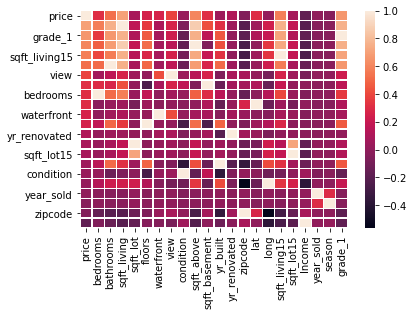

In [1184]:
initial_corr = df.corr().sort_values(by="price", ascending=False)
ax = sns.heatmap(initial_corr, linewidth=0.5)
plt.show()
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [1185]:
#Runnign function to clean data
data_cleaning(df)

df_cat =pd.get_dummies(df_cat, columns=["bedrooms","bathrooms","floors","waterfront","view","condition","season","grade",'zipcode'], drop_first= True)
df = pd.concat([df_numerical, df_cat], axis=1)
df

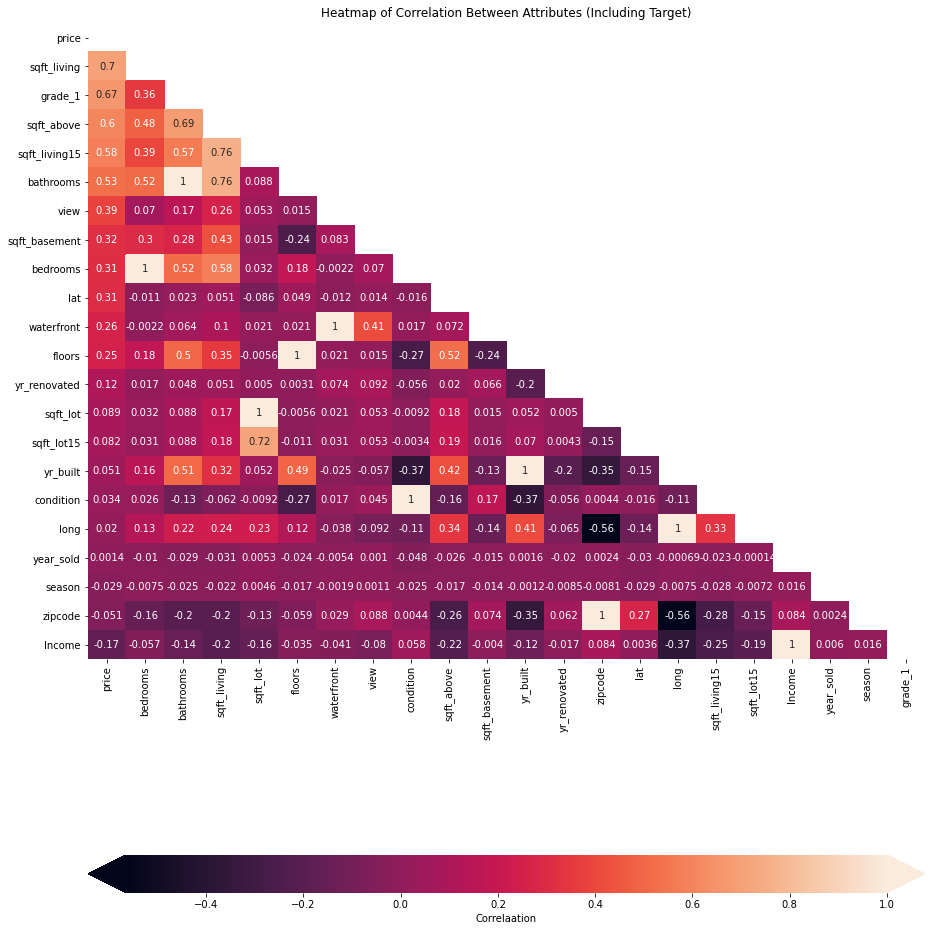

In [1186]:
#Showing correlation between features
initial_corr = df.corr().sort_values(by="price", ascending=False)
fig, ax = plt.subplots(figsize=(15,18))
sns.heatmap(data = initial_corr, mask = np.triu(np.ones_like(initial_corr, dtype=bool)), ax = ax, annot = True, cbar_kws = {"label": "Correlaation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [1187]:
#Model for highest correlation
high_corr_formula = 'price ~ sqft_living'
high_corr_formula = ols(formula=high_corr_formula, data=df).fit()
singular_model = high_corr_formula.summary()
print(singular_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.073e+04
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:25:45   Log-Likelihood:            -2.9763e+05
No. Observations:               21420   AIC:                         5.953e+05
Df Residuals:                   21418   BIC:                         5.953e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.255e+04   4436.470     -9.591      

In [1188]:
#First OLS model
OLS_reg(df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     2436.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:25:45   Log-Likelihood:            -2.9181e+05
No. Observations:               21420   AIC:                         5.837e+05
Df Residuals:                   21398   BIC:                         5.838e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -6.11e+07   6.81e+06     -8.966

X_train shape (17136, 21)
X_test shape (4284, 21)
y_train shape (17136,)
y_test shape (4284,)
R^2 0.7068266165885687
Test R^2 0.6960127596452008
Mean Absolute Error: 124579.0255159566
Mean Squared Error: 38055511381.47631
Root Mean Squared Error: 195078.2186239056
      Actual value  Predicted value  Difference
1453      568000.0        472900.77    95099.23
1008      325000.0        209134.48   115865.52
3115      562500.0        373620.39   188879.61
1800      310000.0        468583.39   158583.39
2058      635000.0        897640.95   262640.95
3193      375000.0        394306.71    19306.71
1165      335000.0        152000.51   182999.49
3167      194000.0        271194.09    77194.09
3921      254000.0        322895.46    68895.46
2147      495000.0        505739.07    10739.07


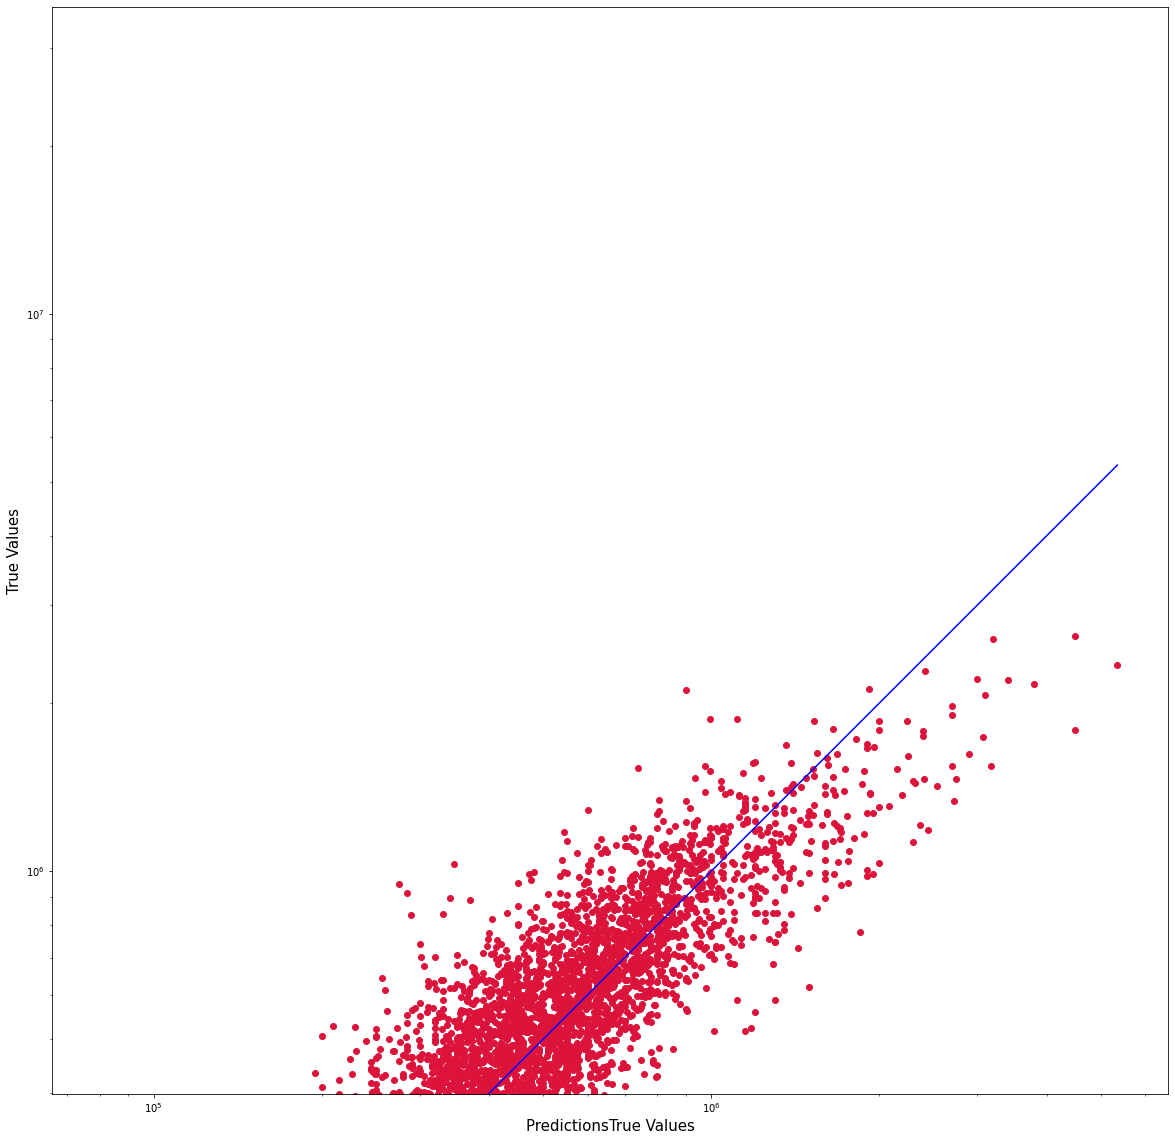

In [1189]:
#First Predictive model
predictive_model(df)

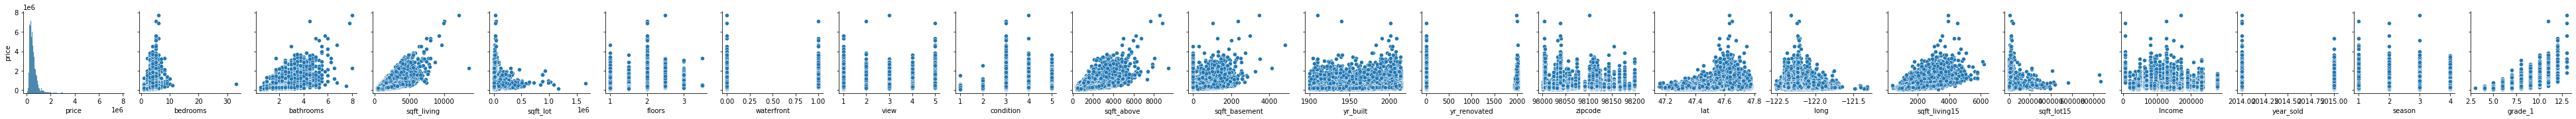

In [1190]:
#Plotting data to check for correlation and outliers
sns.pairplot(df, y_vars="price")

As we can see from the charts there are some outliers that need to be addressed, after the outliers are addressed we will also need to log tranform some of our data to turn into normal distribution

<AxesSubplot:>

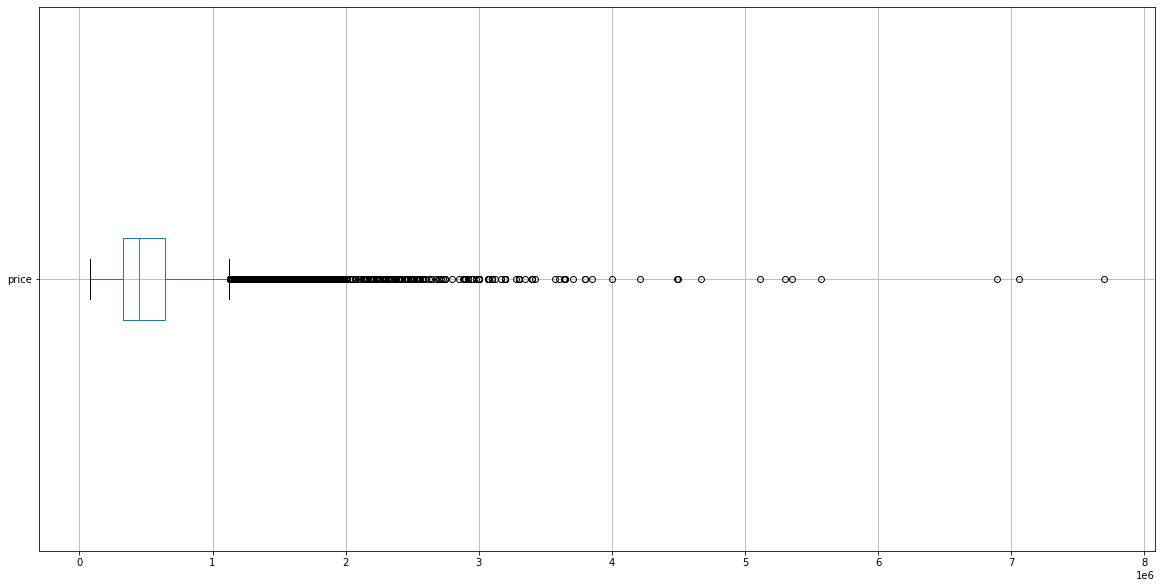

In [1191]:
df.boxplot('price', vert=False, figsize=(20,10))

In [1192]:
df = df[df["price"] < 1500000]

<AxesSubplot:>

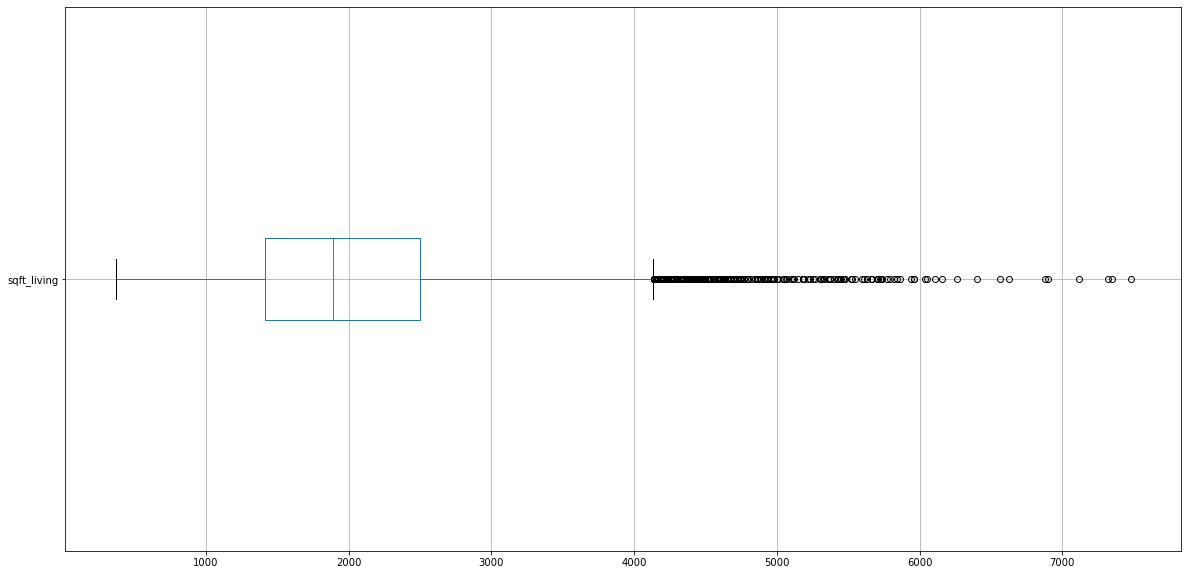

In [1193]:
df.boxplot('sqft_living', vert=False, figsize=(20,10))

In [1194]:
#Dropping outliers from sqft_living
df = df[(np.abs(stats.zscore(df["sqft_living"])) < 3)]

<AxesSubplot:>

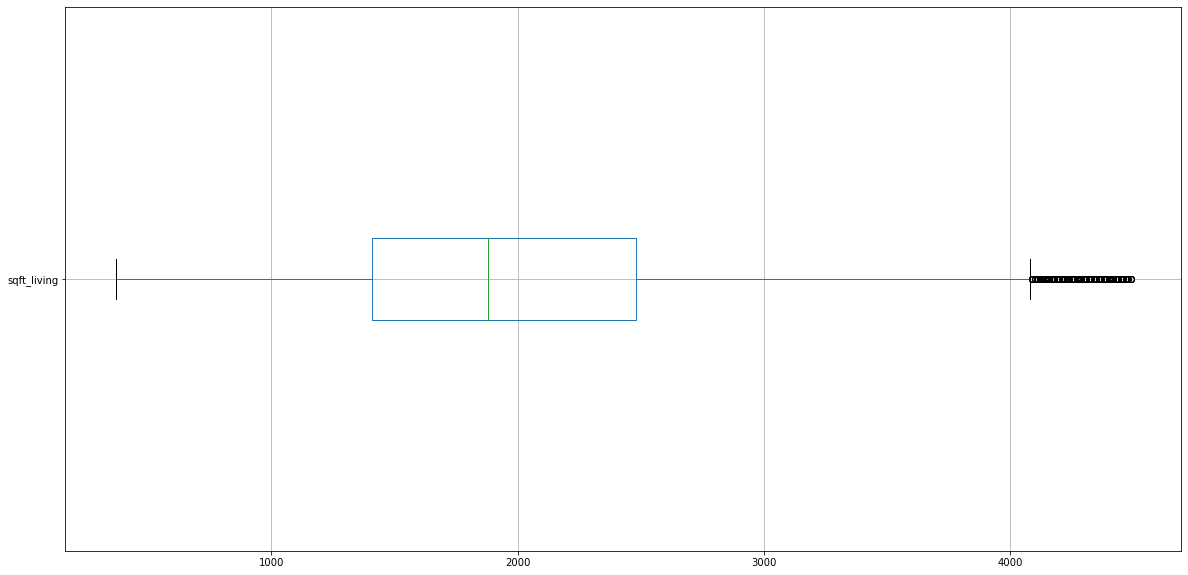

In [1195]:
#Boxplot for sqft_living sqft_living
df.boxplot('sqft_living', vert=False, figsize=(20,10))

In [1196]:
#Model with outliers removed
second_model = OLS_reg(df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     2365.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:25:50   Log-Likelihood:            -2.7333e+05
No. Observations:               20711   AIC:                         5.467e+05
Df Residuals:                   20689   BIC:                         5.469e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -5.78e+07   4.53e+06    -12.756

X_train shape (16568, 21)
X_test shape (4143, 21)
y_train shape (16568,)
y_test shape (4143,)
R^2 0.7034077805865196
Test R^2 0.7152178080769747
Mean Absolute Error: 93871.58816758812
Mean Squared Error: 16571901283.40889
Root Mean Squared Error: 128731.89691529016
      Actual value  Predicted value  Difference
1928      435000.0        301543.08   133456.92
2376      735000.0        676746.40    58253.60
1624      750000.0        551354.54   198645.46
3397      963990.0        889309.51    74680.49
2941      592500.0        630878.78    38378.78
2135      320000.0        533865.40   213865.40
3460      851000.0        837849.87    13150.13
774       390000.0        475778.15    85778.15
1479      235000.0        247422.11    12422.11
679       548050.0        525241.75    22808.25


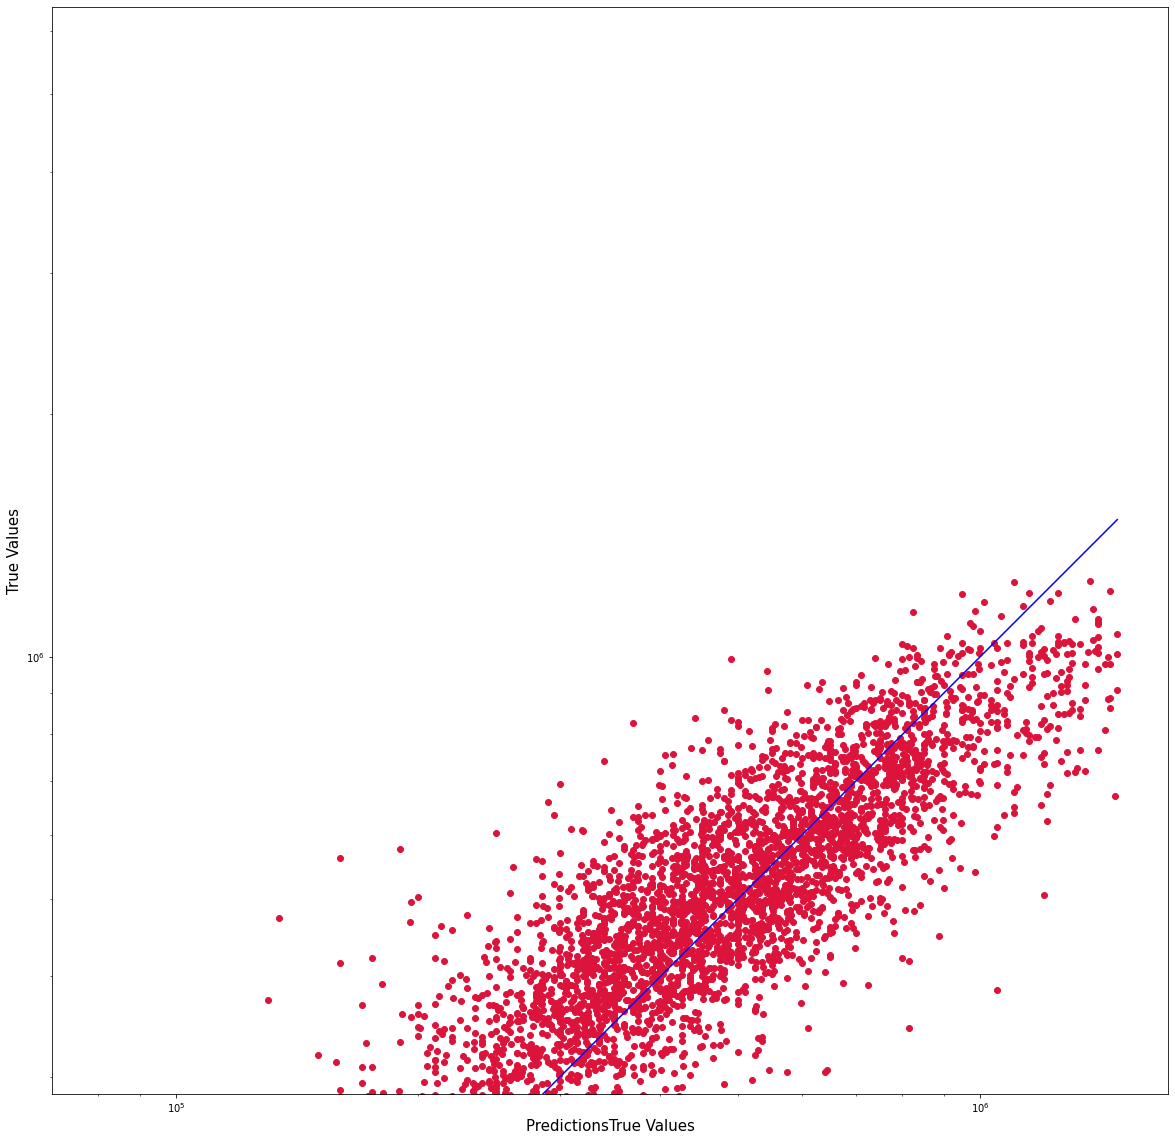

In [1197]:
#Predictive model with outliers removed
predictive_model(df)

In [1198]:
#Creating dataframe for just numerical values
df_numerical = df[['price', "sqft_living","sqft_lot","sqft_above","sqft_basement","yr_built","lat","long","sqft_living15","sqft_lot15",'Income', 'year_sold']].copy().apply(lambda x: np.log(abs(x+1)))

df2 =  df[["bedrooms","bathrooms","floors","waterfront","view","condition","season","grade",'zipcode']]

In [1199]:
log_df = pd.concat([df_numerical, df], axis=1)

In [1200]:
log_df

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,Income,year_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Income,year_sold,season,grade_1
0,12.309987,7.074117,8.639588,7.074117,0.000000,7.578657,3.881795,4.797912,7.201171,8.639588,11.640051,7.608374,221900.0,3,1.00,1180,5650,1.0,0.0,1.0,3,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,113555.0,2014,3.0,7.0
1,12.232841,6.781058,8.821880,6.781058,0.000000,7.573531,3.881582,4.797838,7.082549,8.821880,11.640051,7.608374,205425.0,2,1.00,880,6780,1.0,0.0,1.0,4,880,0.0,1945,0.0,98178,47.5009,-122.248,1190,6780,113555.0,2014,1.0,6.0
2,13.005832,7.650169,9.012133,7.390799,6.175867,7.584773,3.881751,4.797805,7.886457,9.072571,11.640051,7.608374,445000.0,3,2.25,2100,8201,1.0,0.0,2.0,3,1620,480.0,1967,0.0,98178,47.5091,-122.244,2660,8712,113555.0,2014,2.0,8.0
3,12.371591,7.170888,8.682538,7.170888,0.000000,7.581720,3.881673,4.797896,7.186144,8.938532,11.640051,7.608374,236000.0,3,1.00,1300,5898,1.0,0.0,1.0,3,1300,0.0,1961,0.0,98178,47.5053,-122.255,1320,7619,113555.0,2014,2.0,7.0
4,12.043560,6.758095,8.569026,6.758095,0.000000,7.566311,3.881663,4.798036,7.409136,9.079776,11.640051,7.608871,170000.0,2,1.00,860,5265,1.0,0.0,1.0,3,860,0.0,1931,0.0,98178,47.5048,-122.272,1650,8775,113555.0,2015,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21398,14.046623,8.042699,9.203416,7.403061,7.293698,7.578145,3.883854,4.797657,8.202756,9.574983,8.880586,7.608374,1260000.0,3,2.50,3110,9930,1.0,0.0,4.0,3,1640,1470.0,1954,0.0,98039,47.6112,-122.226,3650,14399,7190.0,2014,2.0,8.0
21404,13.997833,7.673688,9.002085,7.673688,0.000000,7.577634,3.884313,4.797739,7.372118,9.002085,8.880586,7.608871,1200000.0,4,3.00,2150,8119,2.0,0.0,1.0,3,2150,0.0,1953,2004.0,98039,47.6335,-122.236,1590,8119,7190.0,2015,1.0,8.0
21407,14.187075,8.036250,9.896765,8.036250,0.000000,7.577634,3.884101,4.797731,7.996654,9.896614,8.880586,7.608374,1450000.0,5,2.75,3090,19865,1.0,0.0,1.0,4,3090,0.0,1953,0.0,98039,47.6232,-122.235,2970,19862,7190.0,2014,3.0,9.0
21410,14.115616,7.635787,9.169623,7.372118,6.175867,7.574045,3.883953,4.797764,8.006701,9.693754,8.880586,7.608374,1350000.0,3,2.00,2070,9600,1.0,0.0,4.0,3,1590,480.0,1946,0.0,98039,47.6160,-122.239,3000,16215,7190.0,2014,2.0,7.0


#Log transformed 
OLS_reg(log_df)


X_train shape (16568, 33)
X_test shape (4143, 33)
y_train shape (16568,)
y_test shape (4143,)
R^2 0.9465197688516027
Test R^2 0.9429666699376806
Mean Absolute Error: 39870.746798450506
Mean Squared Error: 6642927220.889439
Root Mean Squared Error: 81504.154623488
      Actual value  Predicted value  Difference
208       535001.0        455016.42    79984.58
650       530001.0        486736.61    43264.39
2974      435001.0        401898.46    33102.54
1511      730001.0        732504.25     2503.25
1356      710001.0        696415.84    13585.16
340       500001.0        497047.43     2953.57
1424      970001.0        953492.65    16508.35
1844      485001.0        456178.85    28822.15
2968      595001.0        590209.66     4791.34
1538      299001.0        301462.49     2461.49


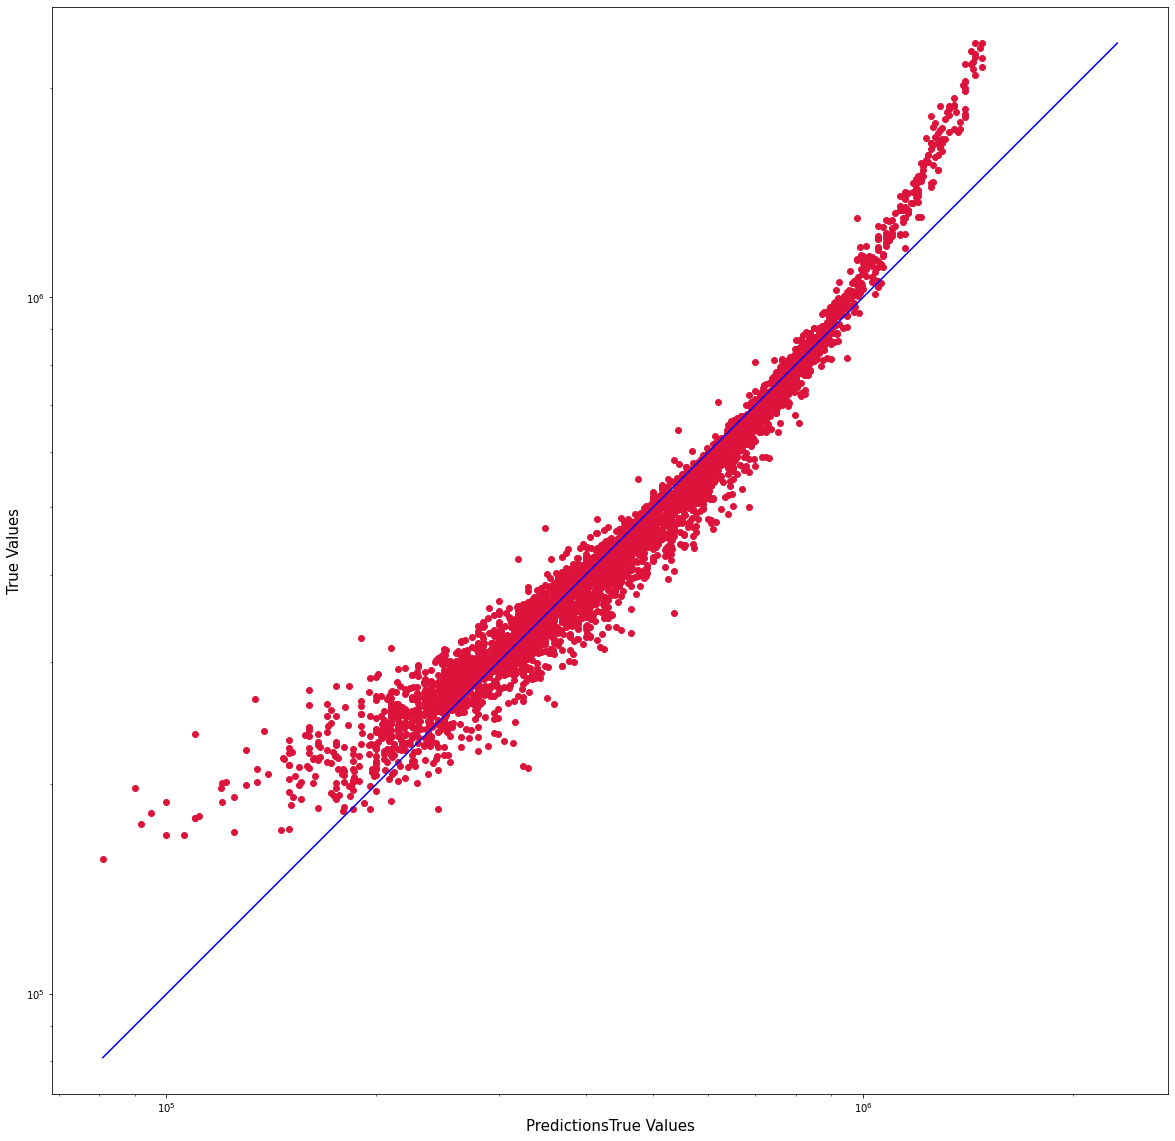

In [1201]:
#Running predictive model for logged data
predictive_model_log(log_df)

In [1202]:
#Feature selection
df_selection = df[["price",'sqft_living', 'lat','bedrooms','bathrooms','floors',"view"]]

In [1203]:
#Running OLS regression on selected features 
OLS_reg(df_selection)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     5020.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:25:51   Log-Likelihood:            -2.7670e+05
No. Observations:               20711   AIC:                         5.534e+05
Df Residuals:                   20704   BIC:                         5.535e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.134e+07   3.63e+05    -86.218      

X_train shape (16568, 6)
X_test shape (4143, 6)
y_train shape (16568,)
y_test shape (4143,)
R^2 0.590941206722335
Test R^2 0.5992198004724806
Mean Absolute Error: 110920.12034246276
Mean Squared Error: 23321998675.78157
Root Mean Squared Error: 152715.4172825441
      Actual value  Predicted value  Difference
3855      367500.0        303257.67    64242.33
320       619000.0        521820.54    97179.46
13        850000.0        493644.48   356355.52
77        748000.0        692353.90    55646.10
311       715000.0        535543.93   179456.07
2970      730100.0        679803.46    50296.54
1897      940000.0        499016.52   440983.48
648       195000.0        477186.05   282186.05
833       535100.0        640157.42   105057.42
3844      575000.0        589210.58    14210.58


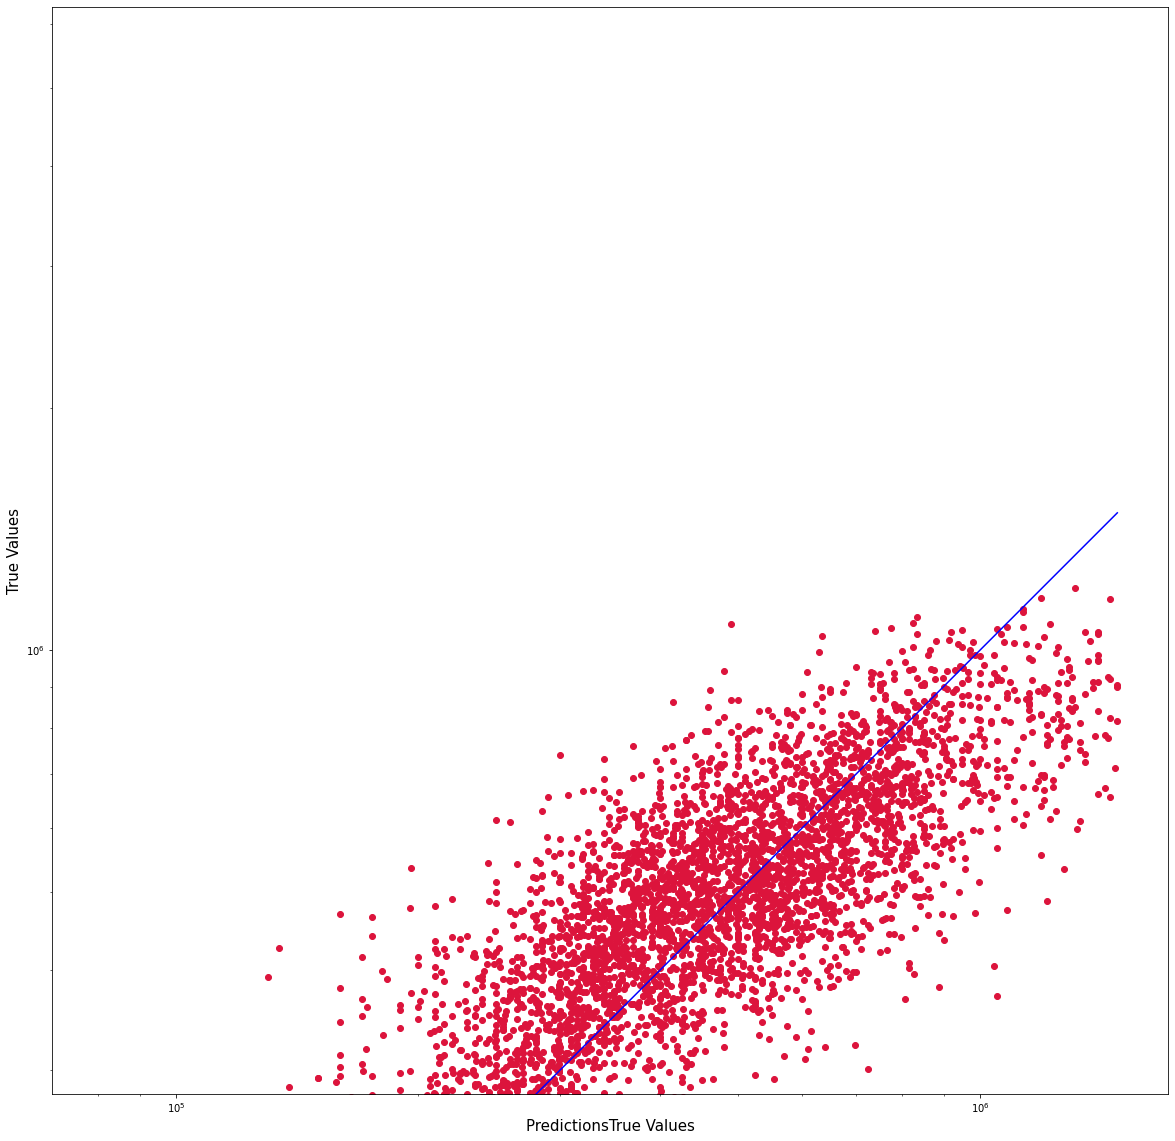

In [1204]:
#Running prediction model on selected features
predictive_model(df_selection)

In [1205]:
#Running polynomial function for selected features 
poly_model(df_selection)

Train degree 2 0.6283718941988619
Test degree 2 0.6350773684512176
train degree 2 0.6283718941988619
Train degree 3 0.6383736473901562
Test degree 3 -28.30068939895004
train degree 3 0.6383736473901562
